# Часть 2. Данные датчиков TreeTalkers

In [77]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# библиотека для визуализации
# %matplotlib widget
import matplotlib.pyplot as plt
from libpysal.weights import Queen
from esda.moran import Moran
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import spearmanr
import matplotlib.lines as mlines

In [35]:
ttdata = pd.read_csv('mos_data.csv')
ttdata.head()

,Unnamed: 0,Site,Species,TT_ID,Timestamp,Bat_mV,Tair,RH,VPD,Tref_0,...,AS7262_650_R,lat,lon,charge,CloudName,TTver,years,months,doys,hours
0,1,RUDN campus,Tilia cordata,218A0060,2021-06-16 10:30:00,4042.691249,20.1,88,0.239423,23.0,...,NaN,55.651734,37.501485,1,C18A0031,2,2021.0,6.0,167.0,10.0
1,2,RUDN campus,Tilia cordata,218A0060,2021-06-16 12:00:00,4042.611417,20.5,87,0.265121,22.1,...,NaN,55.651734,37.501485,1,C18A0031,2,2021.0,6.0,167.0,12.0
2,3,RUDN campus,Tilia cordata,218A0060,2021-06-16 13:30:00,4042.611417,21.3,86,0.298252,23.0,...,NaN,55.651734,37.501485,1,C18A0031,2,2021.0,6.0,167.0,13.0
3,4,RUDN campus,Tilia cordata,218A0060,2021-06-16 15:00:00,4042.611417,22.1,86,0.311484,23.3,...,0.031900,55.651734,37.501485,1,C18A0031,2,2021.0,6.0,167.0,15.0
4,5,RUDN campus,Tilia cordata,218A0060,2021-06-16 16:30:00,4042.611417,22.5,85,0.341025,22.8,...,0.021273,55.651734,37.501485,1,C18A0031,2,2021.0,6.0,167.0,16.0


In [4]:
# все виды, с которыми мы работаем
species = ttdata.Species.unique()
species

array(['Tilia cordata', 'Acer platanoides', 'Populus tremula',
       'Quercus robur', 'Pinus silvestris', 'Betula alba',
       'Betula pendula', 'Picea abies', 'Picea pungens',
       'Acer saccharinum', 'TTR'], dtype=object)

In [6]:
# общее количество датчиков, с которыми мы работаем
tt_ID = ttdata['TT_ID'][ttdata.Species != 'TTR'].unique()
len(tt_ID)

78

In [6]:
ttdata.columns

Index(['Unnamed: 0', 'Site', 'Species', 'TT_ID', 'Timestamp', 'Bat_mV', 'Tair',
       'RH', 'VPD', 'Tref_0', 'Accel', 'Theta', 'Psi', 'Phi', 'Osc_fct',
       'growth', 'StWC', 'Fd', 'Fdh', 'dTmax', 'DBH', 'Flux', 'NDVI',
       'AS7263_610_R', 'AS7263_680_R', 'AS7263_760_R', 'AS7263_810_R',
       'AS7263_860_R', 'AS7262_450_R', 'AS7262_500_R', 'AS7262_550_R',
       'AS7262_570_R', 'AS7262_600_R', 'AS7262_650_R', 'lat', 'lon', 'charge',
       'CloudName', 'TTver', 'years', 'months', 'doys', 'hours'],
      dtype='object')

In [7]:
spec_flux_dict = pd.DataFrame(index = range(1,12),columns= ['Species', 'meanFlux'])
for i in range(len(species)):
    speci = ttdata[ttdata['Species'] == species[i]]
    mean_flux = speci['Flux'].mean()
    spec_flux_dict.iloc[i, 0] = species[i]
    spec_flux_dict.iloc[i, 1] = mean_flux
spec_flux_dict

,Species,meanFlux
1,Tilia cordata,inf
2,Acer platanoides,1.067406
3,Populus tremula,inf
4,Quercus robur,12.246365
5,Pinus silvestris,18.592399
6,Betula alba,3.819951
7,Betula pendula,0.966249
8,Picea abies,1.472444
9,Picea pungens,0.905093
10,Acer saccharinum,0.434393


In [63]:
# convert the "Timestamp" column to a datetime format
ttdata['Timestamp'] = pd.to_datetime(ttdata['Timestamp'])

# округляем данные по 30 минут, потому что некоторые измерения проводятся с опозданием в несколько секунд
# если тритокеру надо отправить данные в облако 
ttdata['Timestamp'] = ttdata['Timestamp'].dt.round('30min').dt.strftime('%Y-%m-%d %H:%M:%S')
ttdata['Timestamp'] = pd.to_datetime(ttdata['Timestamp'])

# check to see if the conversion was successful
# print(ttdata['Timestamp'].dtypes)
ttdata.head()
# убрать лишние колонки

,Unnamed: 0,Site,Species,TT_ID,Timestamp,Bat_mV,Tair,RH,VPD,Tref_0,...,AS7262_650_R,lat,lon,charge,CloudName,TTver,years,months,doys,hours
0,1,RUDN campus,Tilia cordata,218A0060,2021-06-16 10:30:00,4042.691249,20.1,88,0.239423,23.0,...,NaN,55.651734,37.501485,1,C18A0031,2,2021.0,6.0,167.0,10.0
1,2,RUDN campus,Tilia cordata,218A0060,2021-06-16 12:00:00,4042.611417,20.5,87,0.265121,22.1,...,NaN,55.651734,37.501485,1,C18A0031,2,2021.0,6.0,167.0,12.0
2,3,RUDN campus,Tilia cordata,218A0060,2021-06-16 13:30:00,4042.611417,21.3,86,0.298252,23.0,...,NaN,55.651734,37.501485,1,C18A0031,2,2021.0,6.0,167.0,13.0
3,4,RUDN campus,Tilia cordata,218A0060,2021-06-16 15:00:00,4042.611417,22.1,86,0.311484,23.3,...,0.031900,55.651734,37.501485,1,C18A0031,2,2021.0,6.0,167.0,15.0
4,5,RUDN campus,Tilia cordata,218A0060,2021-06-16 16:30:00,4042.611417,22.5,85,0.341025,22.8,...,0.021273,55.651734,37.501485,1,C18A0031,2,2021.0,6.0,167.0,16.0


In [17]:
ttdata.iloc[:, 15:]

,growth,StWC,Fd,Fdh,dTmax,DBH,Flux,NDVI,AS7263_610_R,AS7263_680_R,...,AS7262_650_R,lat,lon,charge,CloudName,TTver,years,months,doys,hours
0,0.0,0.290277,1.351440e-06,4.865185,7.8,82.0,0.294928,NaN,NaN,NaN,...,NaN,55.651734,37.501485,1,C18A0031,2,2021.0,6.0,167.0,10.0
1,0.0,0.280067,1.640886e-05,59.071893,7.8,82.0,3.580946,NaN,NaN,NaN,...,NaN,55.651734,37.501485,1,C18A0031,2,2021.0,6.0,167.0,12.0
2,0.0,0.243836,0.000000e+00,0.000000,7.8,82.0,0.000000,NaN,NaN,NaN,...,NaN,55.651734,37.501485,1,C18A0031,2,2021.0,6.0,167.0,13.0
3,0.0,0.187095,3.278099e-06,11.801156,7.8,82.0,0.715388,0.742175,0.047948,0.028888,...,0.031900,55.651734,37.501485,1,C18A0031,2,2021.0,6.0,167.0,15.0
4,0.0,0.177846,9.695267e-06,34.902960,7.8,82.0,2.115822,0.839011,0.025708,0.020950,...,0.021273,55.651734,37.501485,1,C18A0031,2,2021.0,6.0,167.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163143,0.0,0.166845,7.397352e-07,2.663047,6.3,118.0,0.319742,1.000000,0.250000,0.000000,...,0.000000,55.472765,37.299727,8,C18A0027,2,2022.0,8.0,230.0,21.0
163144,0.0,0.164829,0.000000e+00,0.000000,6.3,118.0,0.000000,NaN,NaN,NaN,...,NaN,55.472765,37.299727,8,C18A0027,2,2022.0,8.0,230.0,22.0
163145,0.0,0.164027,7.113821e-07,2.560975,6.5,118.0,0.307487,1.000000,0.200000,0.000000,...,0.000000,55.472765,37.299727,8,C18A0027,2,2022.0,8.0,231.0,0.0
163146,0.0,0.167289,0.000000e+00,0.000000,6.5,118.0,0.000000,NaN,NaN,NaN,...,NaN,55.472765,37.299727,8,C18A0027,2,2022.0,8.0,231.0,1.0


In [87]:
ttdata.Site.unique()

array(['RUDN campus', 'Moscow Timiryazev Forest', 'Zaryadye', 'Troitsk'],
      dtype=object)

/tmp/ipykernel_21282/2806053691.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_plot['Data_Gap'] = data_to_plot['Timestamp'].diff() > pd.Timedelta(hours=2) # considering gap if difference more than 2 hours
/tmp/ipykernel_21282/2806053691.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_plot.loc[data_to_plot['Data_Gap'] == np.bool_(False), 'Data_Gap'] = np.nan
/tmp/ipykernel_21282/2806053691.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

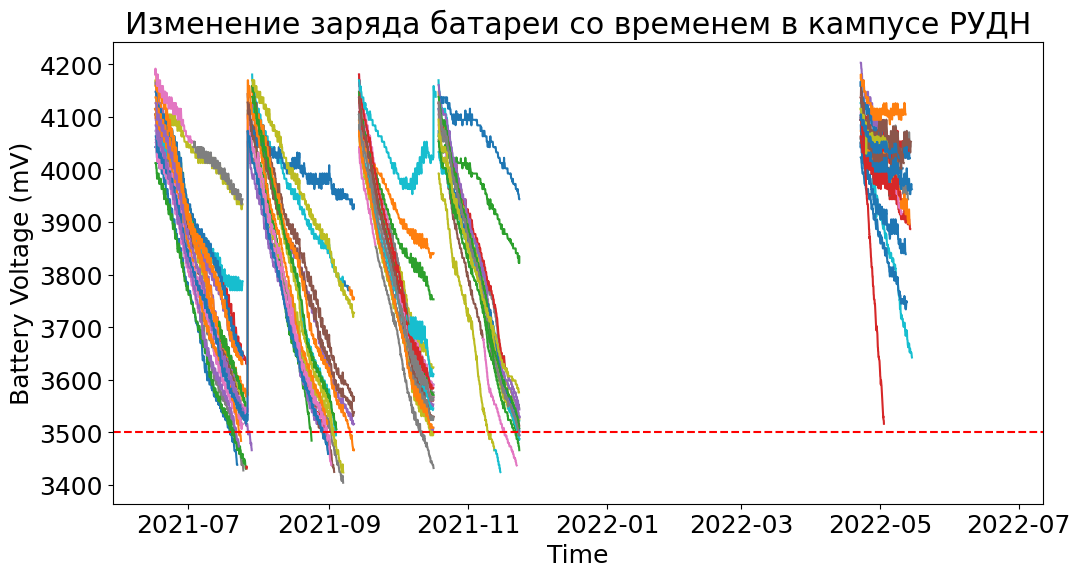

In [16]:
# Filter to include only RUDN campus data
df_rudn = ttdata[ttdata['Site'] == 'RUDN campus']

# Group data by 'TT_ID' and 'Timestamp'
grouped = df_rudn.groupby(['TT_ID', 'Timestamp'])['Bat_mV'].mean().reset_index()

plt.figure(figsize=(12,6))

# Go through each TT_ID
for tt_id in grouped['TT_ID'].unique():
    data_to_plot = grouped[grouped['TT_ID'] == tt_id]

    # Check for missing data
    data_to_plot['Data_Gap'] = data_to_plot['Timestamp'].diff() > pd.Timedelta(hours=2) # considering gap if difference more than 2 hours
    data_to_plot.loc[data_to_plot['Data_Gap'] == np.bool_(False), 'Data_Gap'] = np.nan

    # Plot segments of continuous data
    for (gap, segment) in data_to_plot.groupby(data_to_plot['Data_Gap'].notnull().cumsum()):
        plt.plot(segment['Timestamp'], segment['Bat_mV'], label=f'TT ID: {tt_id}')

plt.title('Изменение заряда батареи со временем в кампусе РУДН')
plt.xlabel('Time')
plt.ylabel('Battery Voltage (mV)')
plt.axhline(3500, color='r', linestyle='--')  # Add line at 3500
plt.show()

In [18]:
# Count of active TreeTalkers at each timestamp
active_talkers = df_rudn.groupby('Timestamp')['TT_ID'].nunique()
print(active_talkers)

Timestamp
2021-06-16 07:30:00     1
2021-06-16 09:00:00     1
2021-06-16 10:30:00     5
2021-06-16 12:00:00     7
2021-06-16 13:30:00    10
                       ..
2022-05-14 22:30:00     2
2022-05-15 00:00:00     2
2022-05-15 01:30:00     1
2022-06-12 04:30:00     1
2022-06-23 00:00:00     1
Name: TT_ID, Length: 2876, dtype: int64


In [20]:
# Average battery voltage for each TreeTalker
average_bat_voltage = df_rudn.groupby('Timestamp')['Bat_mV'].mean()
print(average_bat_voltage)

Timestamp
2021-06-16 07:30:00    4115.096494
2021-06-16 09:00:00    4113.847780
2021-06-16 10:30:00    4122.618340
2021-06-16 12:00:00    4096.783193
2021-06-16 13:30:00    4101.575102
                          ...     
2022-05-14 22:30:00    3804.235686
2022-05-15 00:00:00    3803.305834
2022-05-15 01:30:00    3642.387199
2022-06-12 04:30:00    4073.626909
2022-06-23 00:00:00    3895.671064
Name: Bat_mV, Length: 2876, dtype: float64


In [86]:
# df_rudn = df_rudn.dropna(subset=['Timestamp'])
# df_rudn['Timestamp'] = df_rudn['Timestamp'].apply(lambda x: x.timestamp())

# earliest_timestamp = df_rudn['Timestamp'].min()
# df_rudn['Timestamp'] = df_rudn['Timestamp'].fillna(earliest_timestamp)
# df_rudn['Timestamp'] = df_rudn['Timestamp'].apply(lambda x: x.timestamp())

# Count of active TreeTalkers at each timestamp
active_talkers = df_rudn.groupby('Timestamp')['TT_ID'].nunique()
print(active_talkers)

# Average battery voltage for each TreeTalker
average_bat_voltage = df_rudn.groupby('Timestamp')['Bat_mV'].min()
# Calculate the minimum battery voltage at each timestamp
min_bat_voltage = df_rudn.groupby('Timestamp')['Bat_mV'].mean()

# Add the minimum battery voltage values to the DataFrame as a new column
df_bat = pd.merge(average_bat_voltage, min_bat_voltage, how='left', on='Timestamp')
df_bat.rename(columns={'Bat_mV_y': 'Min_Bat_mV', 'Bat_mV_x': 'Avg_Bat_mV'}, inplace=True)
print(df_bat)

# Calculate Spearman correlation
corr, p_value = spearmanr(average_bat_voltage, active_talkers)

print('Spearmans correlation: %.10f' % corr)
print('p-value: %.10f' % p_value)

Timestamp
1.623829e+09     1
1.623834e+09     1
1.623839e+09     5
1.623845e+09     7
1.623850e+09    10
                ..
1.652567e+09     2
1.652573e+09     2
1.652578e+09     1
1.655008e+09     1
1.655942e+09     1
Name: TT_ID, Length: 2876, dtype: int64
               Avg_Bat_mV   Min_Bat_mV
Timestamp                             
1.623829e+09  4115.096494  4115.096494
1.623834e+09  4113.847780  4113.847780
1.623839e+09  4042.691249  4122.618340
1.623845e+09  4012.231239  4096.783193
1.623850e+09  4012.152834  4101.575102
...                   ...          ...
1.652567e+09  3645.682437  3804.235686
1.652573e+09  3644.127175  3803.305834
1.652578e+09  3642.387199  3642.387199
1.655008e+09  4073.626909  4073.626909
1.655942e+09  3895.671064  3895.671064

[2876 rows x 2 columns]
Spearmans correlation: 0.3115170192
p-value: 0.0000000000


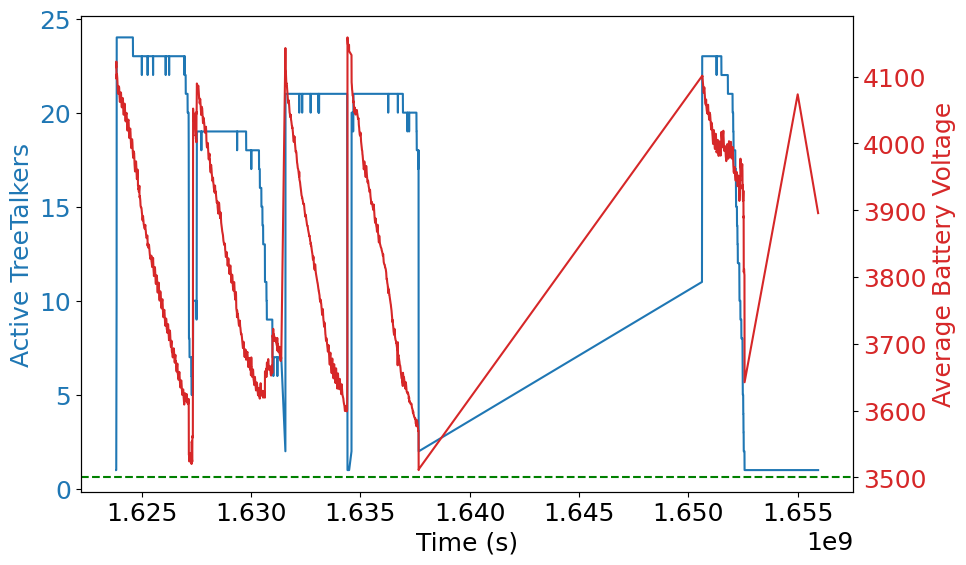

In [46]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
# Make the y-axis label and tick labels match the line color.
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Active TreeTalkers', color=color)
ax1.plot(active_talkers.index, active_talkers, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second y-axis that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Average Battery Voltage', color=color)
ax2.plot(average_bat_voltage.index, average_bat_voltage, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Adding a horizontal line at y=3500 on the second y-axis
ax2.axhline(3500, color='green', linestyle='--')

fig.tight_layout()  # to ensure that the right y-label is not slightly clipped
plt.show()


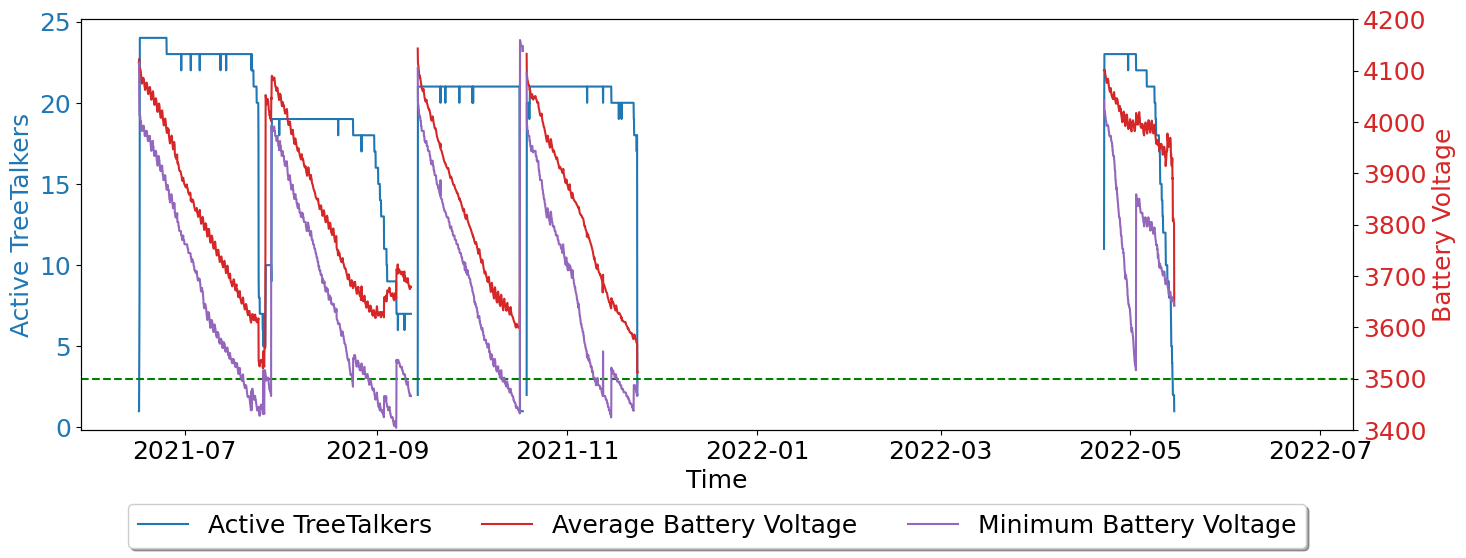

In [81]:
import matplotlib.pyplot as plt
import pandas as pd

fig, ax1 = plt.subplots(figsize=(15, 6))

color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('Active TreeTalkers', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second y-axis that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Battery Voltage', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Set the lower limit for the battery voltage plot to 3500
ax2.set_ylim(bottom=3400, top = 4200)

# Adding a horizontal line at y=3500 on the second y-axis
ax2.axhline(3500, color='green', linestyle='--')

for data, ax, color, label in [(active_talkers, ax1, 'tab:blue', 'Active TreeTalkers'),
                               (df_bat['Avg_Bat_mV'], ax2, 'tab:red', 'Average Battery Voltage'),
                               (df_bat['Min_Bat_mV'], ax2, 'tab:purple', 'Minimum Battery Voltage')]:
    data_to_plot = data.copy()
    data_to_plot = data_to_plot.reset_index()
    data_to_plot['Timestamp'] = pd.to_datetime(data_to_plot['Timestamp'], unit='s')
    data_to_plot.set_index('Timestamp', inplace=True)
    data_to_plot['Data_Gap'] = data_to_plot.index.to_series().diff() > pd.Timedelta(hours=2)
    data_to_plot.loc[data_to_plot['Data_Gap'] == np.bool_(False), 'Data_Gap'] = np.nan
    
    for (gap, segment) in data_to_plot.groupby(data_to_plot['Data_Gap'].notnull().cumsum()):
        ax.plot(segment.index, segment.values, color=color, label=label)

# Create a legend for the whole figure.
handles = [mlines.Line2D([], [], color='tab:blue', label='Active TreeTalkers'),
           mlines.Line2D([], [], color='tab:red', label='Average Battery Voltage'),
           mlines.Line2D([], [], color='tab:purple', label='Minimum Battery Voltage')]
plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3)

fig.tight_layout()
plt.show()

Timestamp
2021-05-24 22:30:00    1
2021-05-25 00:00:00    1
2021-05-25 01:00:00    1
2021-05-25 02:00:00    1
2021-05-25 03:00:00    1
                      ..
2022-08-22 18:00:00    1
2022-08-22 19:30:00    1
2022-08-22 21:00:00    1
2022-08-22 22:30:00    1
2022-08-23 00:00:00    1
Name: TT_ID, Length: 3575, dtype: int64
                      Avg_Bat_mV   Min_Bat_mV
Timestamp                                    
2021-05-24 22:30:00  4174.393971  4174.393971
2021-05-25 00:00:00  4171.608456  4171.608456
2021-05-25 01:00:00  4168.474265  4168.474265
2021-05-25 02:00:00  4165.087316  4165.087316
2021-05-25 03:00:00  4163.323453  4163.323453
...                          ...          ...
2022-08-22 18:00:00  3430.137116  3430.137116
2022-08-22 19:30:00  3428.313864  3428.313864
2022-08-22 21:00:00  3426.519728  3426.519728
2022-08-22 22:30:00  3425.458407  3425.458407
2022-08-23 00:00:00  3425.458407  3425.458407

[3575 rows x 2 columns]
Spearmans correlation: 0.3003796654
p-value: 0.00000

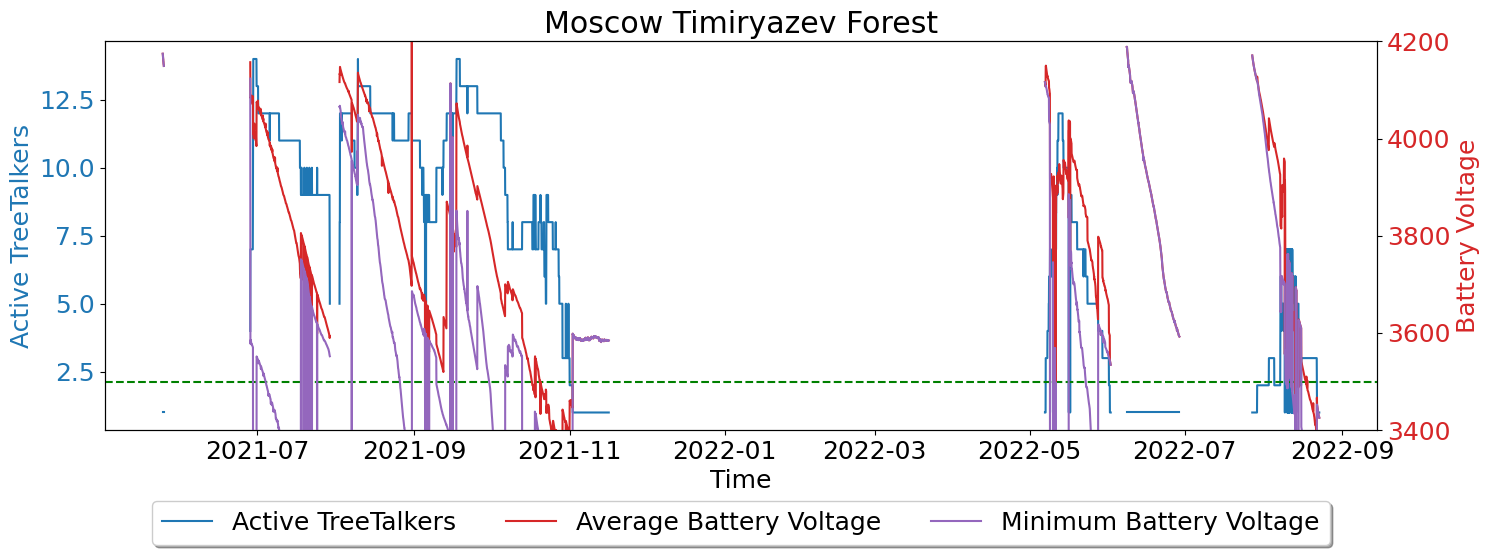

In [90]:
# Filter to include only RUDN campus data
df_tim = ttdata[ttdata['Site'] == 'Moscow Timiryazev Forest']

# Count of active TreeTalkers at each timestamp
active_talkers = df_tim.groupby('Timestamp')['TT_ID'].nunique()
print(active_talkers)

# Average battery voltage for each TreeTalker
average_bat_voltage = df_tim.groupby('Timestamp')['Bat_mV'].mean()
# Calculate the minimum battery voltage at each timestamp
min_bat_voltage = df_tim.groupby('Timestamp')['Bat_mV'].min()

# Add the minimum battery voltage values to the DataFrame as a new column
df_bat = pd.merge(average_bat_voltage, min_bat_voltage, how='left', on='Timestamp')
df_bat.rename(columns={'Bat_mV_y': 'Min_Bat_mV', 'Bat_mV_x': 'Avg_Bat_mV'}, inplace=True)
print(df_bat)

# Calculate Spearman correlation
corr, p_value = spearmanr(average_bat_voltage, active_talkers)

print('Spearmans correlation: %.10f' % corr)
print('p-value: %.10f' % p_value)

fig, ax1 = plt.subplots(figsize=(15, 6))

color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('Active TreeTalkers', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second y-axis that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Battery Voltage', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Set the lower limit for the battery voltage plot to 3500
ax2.set_ylim(bottom=3400, top = 4200)

# Adding a horizontal line at y=3500 on the second y-axis
ax2.axhline(3500, color='green', linestyle='--')

for data, ax, color, label in [(active_talkers, ax1, 'tab:blue', 'Active TreeTalkers'),
                               (df_bat['Avg_Bat_mV'], ax2, 'tab:red', 'Average Battery Voltage'),
                               (df_bat['Min_Bat_mV'], ax2, 'tab:purple', 'Minimum Battery Voltage')]:
    data_to_plot = data.copy()
    data_to_plot = data_to_plot.reset_index()
    data_to_plot['Timestamp'] = pd.to_datetime(data_to_plot['Timestamp'], unit='s')
    data_to_plot.set_index('Timestamp', inplace=True)
    data_to_plot['Data_Gap'] = data_to_plot.index.to_series().diff() > pd.Timedelta(hours=2)
    data_to_plot.loc[data_to_plot['Data_Gap'] == np.bool_(False), 'Data_Gap'] = np.nan
    
    for (gap, segment) in data_to_plot.groupby(data_to_plot['Data_Gap'].notnull().cumsum()):
        ax.plot(segment.index, segment.values, color=color, label=label)

# Create a legend for the whole figure.
handles = [mlines.Line2D([], [], color='tab:blue', label='Active TreeTalkers'),
           mlines.Line2D([], [], color='tab:red', label='Average Battery Voltage'),
           mlines.Line2D([], [], color='tab:purple', label='Minimum Battery Voltage')]
plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3)
plt.title('Moscow Timiryazev Forest')
fig.tight_layout()
plt.show()

Timestamp
2020-10-11 04:30:00    1
2020-10-11 06:00:00    1
2020-10-11 07:30:00    1
2020-10-11 09:00:00    1
2020-10-11 10:30:00    1
                      ..
2022-09-14 06:00:00    1
2022-09-14 07:30:00    1
2022-09-14 09:00:00    1
2022-09-14 10:30:00    1
2022-09-14 12:00:00    1
Name: TT_ID, Length: 5774, dtype: int64
                      Avg_Bat_mV   Min_Bat_mV
Timestamp                                    
2020-10-11 04:30:00  3962.712819  3962.712819
2020-10-11 06:00:00  3958.835544  3958.835544
2020-10-11 07:30:00  3953.150129  3953.150129
2020-10-11 09:00:00  3960.582995  3960.582995
2020-10-11 10:30:00  3981.312384  3981.312384
...                          ...          ...
2022-09-14 06:00:00  4012.231239  4012.231239
2022-09-14 07:30:00  4012.231239  4012.231239
2022-09-14 09:00:00  4012.231239  4012.231239
2022-09-14 10:30:00  4012.231239  4012.231239
2022-09-14 12:00:00  4012.231239  4012.231239

[5774 rows x 2 columns]
Spearmans correlation: 0.2036336076
p-value: 0.00000

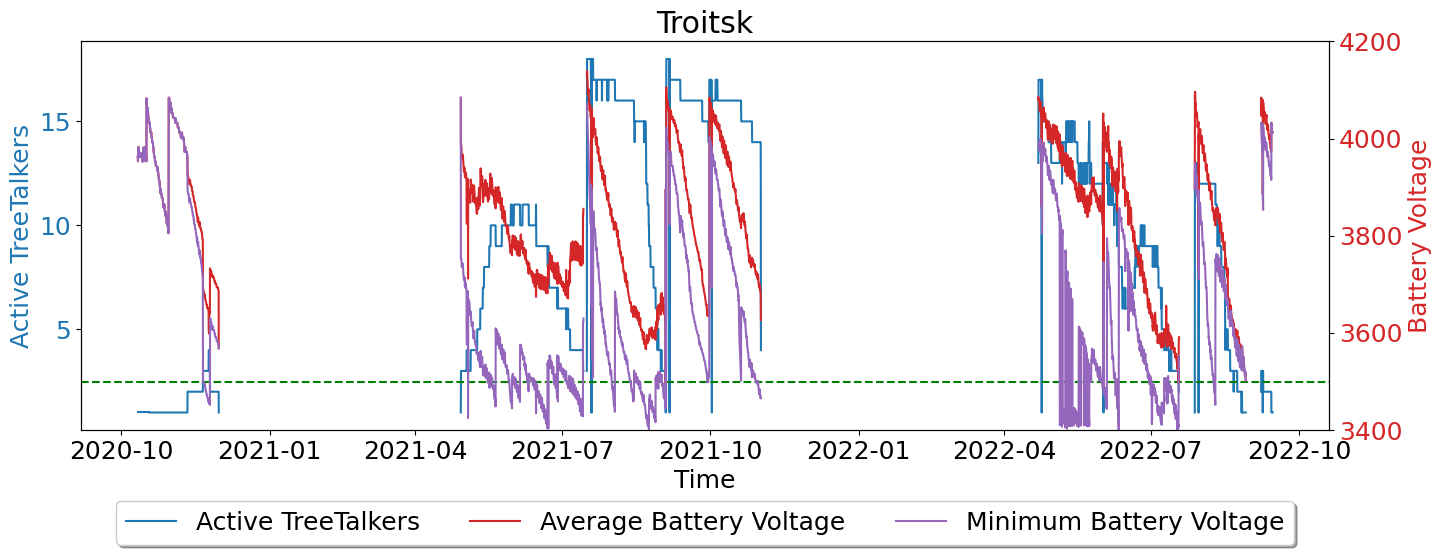

In [93]:
# Filter to include only RUDN campus data
df_tim = ttdata[ttdata['Site'] == 'Troitsk']

# Count of active TreeTalkers at each timestamp
active_talkers = df_tim.groupby('Timestamp')['TT_ID'].nunique()
print(active_talkers)

# Average battery voltage for each TreeTalker
average_bat_voltage = df_tim.groupby('Timestamp')['Bat_mV'].mean()
# Calculate the minimum battery voltage at each timestamp
min_bat_voltage = df_tim.groupby('Timestamp')['Bat_mV'].min()

# Add the minimum battery voltage values to the DataFrame as a new column
df_bat = pd.merge(average_bat_voltage, min_bat_voltage, how='left', on='Timestamp')
df_bat.rename(columns={'Bat_mV_y': 'Min_Bat_mV', 'Bat_mV_x': 'Avg_Bat_mV'}, inplace=True)
print(df_bat)

# Calculate Spearman correlation
corr, p_value = spearmanr(average_bat_voltage, active_talkers)

print('Spearmans correlation: %.10f' % corr)
print('p-value: %.10f' % p_value)

fig, ax1 = plt.subplots(figsize=(15, 6))

color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('Active TreeTalkers', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second y-axis that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Battery Voltage', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Set the lower limit for the battery voltage plot to 3500
ax2.set_ylim(bottom=3400, top = 4200)

# Adding a horizontal line at y=3500 on the second y-axis
ax2.axhline(3500, color='green', linestyle='--')

for data, ax, color, label in [(active_talkers, ax1, 'tab:blue', 'Active TreeTalkers'),
                               (df_bat['Avg_Bat_mV'], ax2, 'tab:red', 'Average Battery Voltage'),
                               (df_bat['Min_Bat_mV'], ax2, 'tab:purple', 'Minimum Battery Voltage')]:
    data_to_plot = data.copy()
    data_to_plot = data_to_plot.reset_index()
    data_to_plot['Timestamp'] = pd.to_datetime(data_to_plot['Timestamp'], unit='s')
    data_to_plot.set_index('Timestamp', inplace=True)
    data_to_plot['Data_Gap'] = data_to_plot.index.to_series().diff() > pd.Timedelta(hours=2)
    data_to_plot.loc[data_to_plot['Data_Gap'] == np.bool_(False), 'Data_Gap'] = np.nan
    
    for (gap, segment) in data_to_plot.groupby(data_to_plot['Data_Gap'].notnull().cumsum()):
        ax.plot(segment.index, segment.values, color=color, label=label)

# Create a legend for the whole figure.
handles = [mlines.Line2D([], [], color='tab:blue', label='Active TreeTalkers'),
           mlines.Line2D([], [], color='tab:red', label='Average Battery Voltage'),
           mlines.Line2D([], [], color='tab:purple', label='Minimum Battery Voltage')]
plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3)
plt.title('Troitsk')
fig.tight_layout()
plt.show()

In [11]:
# посмотреть все уникальные значения времени
unique_timestamps = ttdata['Timestamp'].unique()

# Create DataFrame with timestamps
timestamps_df = pd.DataFrame({'Timestamp': unique_timestamps})

# Write DataFrame to Excel file
# timestamps_df.to_excel('unique_timestamps.xlsx', index=False)

/tmp/ipykernel_21282/2811972001.py:13: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_daily = df_daily.reindex(idx, fill_value=pd.np.nan)


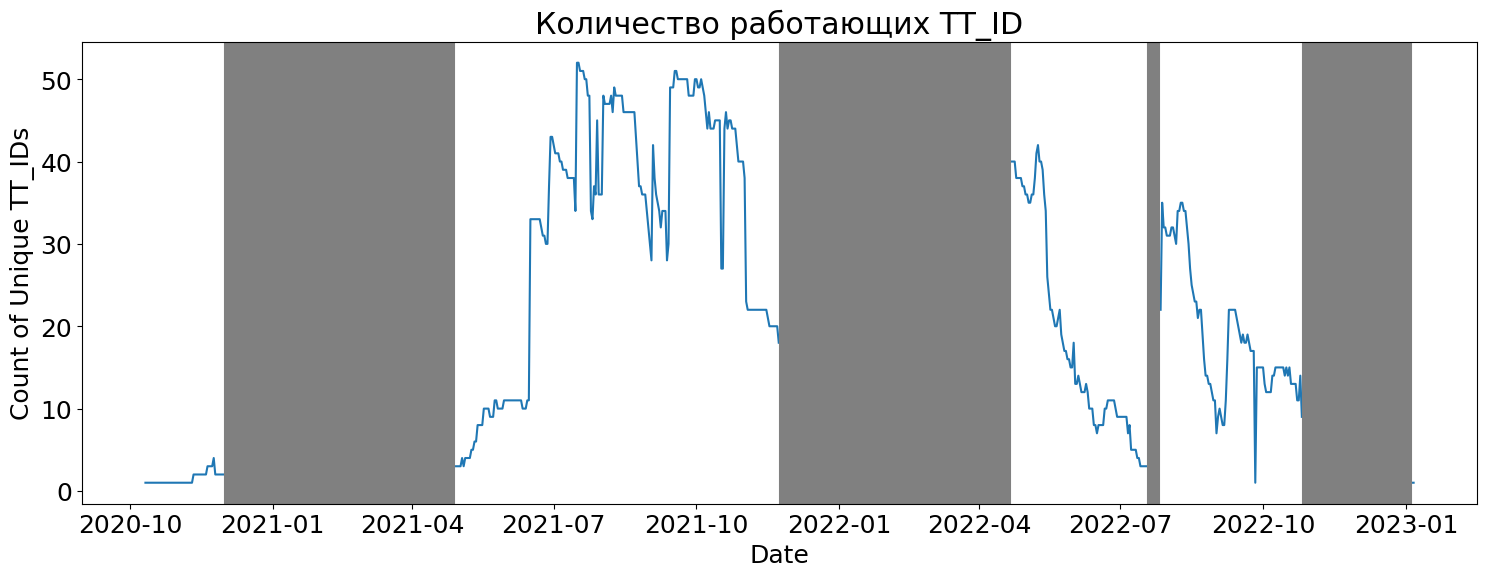

In [8]:
# Group by day and count unique TT_IDs
result_df = ttdata.groupby(ttdata['Timestamp'].dt.date)['TT_ID'].nunique().reset_index()
result_df = result_df.rename(columns={'TT_ID': 'TT_ID_count'})

# set 'Timestamp' column as the index
df = result_df.set_index('Timestamp')

# resample data to daily frequency and interpolate missing values
df_daily = df.interpolate()

# add NaN values for days with missing data
idx = pd.date_range(df_daily.index[0], df_daily.index[-1])
df_daily = df_daily.reindex(idx, fill_value=pd.np.nan)

# Create plot
fig, ax = plt.subplots(figsize=(18,6))

# Setting the plot title and label fonts
plt.rcParams.update({'font.size': 18})

# create plot
plt.plot(df_daily.index, df_daily['TT_ID_count'])

# set x-axis label
plt.xlabel('Date')

# set y-axis label
plt.ylabel('Count of Unique TT_IDs')

# set plot title
plt.title('Количество работающих TT_ID')

# set line breaks for missing data
for i in range(len(df_daily)):
    if pd.isna(df_daily['TT_ID_count'][i]):
        plt.axvline(x=df_daily.index[i], color='grey')

# show plot
plt.show()

In [9]:
df_daily['TT_ID_count'].max()

52.0

/tmp/ipykernel_21282/3121504476.py:20: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_daily = df_daily.reindex(idx, fill_value=pd.np.nan)


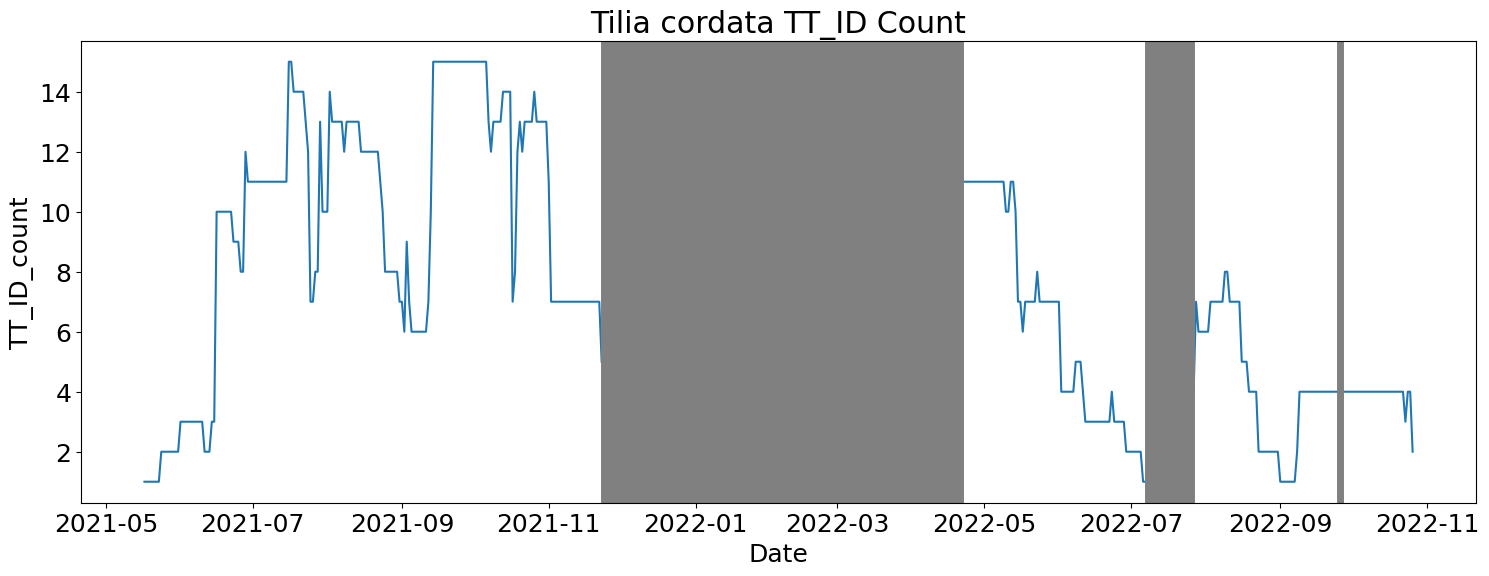

/tmp/ipykernel_21282/3121504476.py:20: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_daily = df_daily.reindex(idx, fill_value=pd.np.nan)


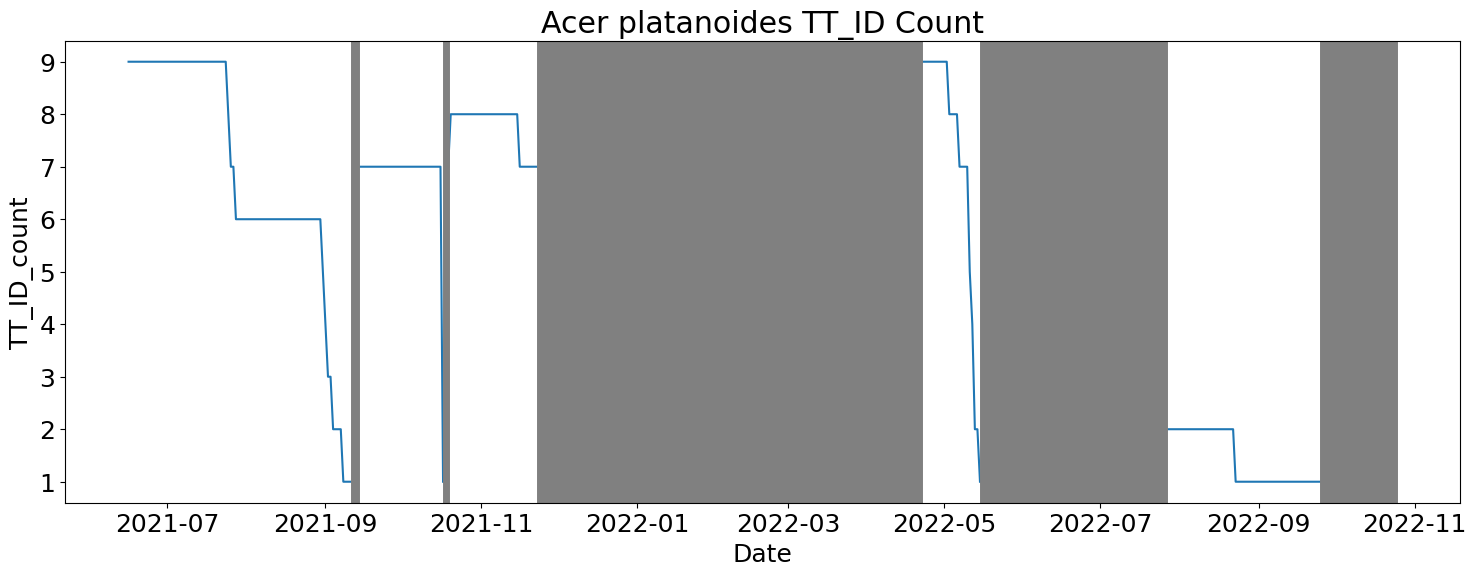

/tmp/ipykernel_21282/3121504476.py:20: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_daily = df_daily.reindex(idx, fill_value=pd.np.nan)


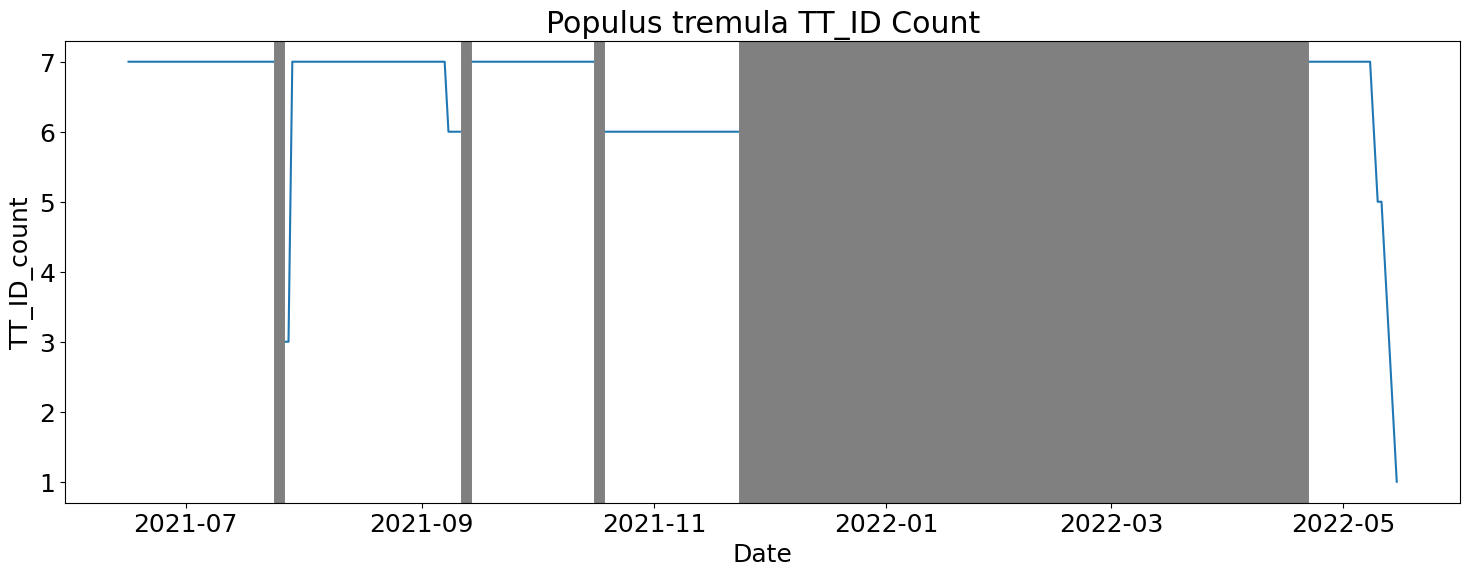

/tmp/ipykernel_21282/3121504476.py:20: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_daily = df_daily.reindex(idx, fill_value=pd.np.nan)


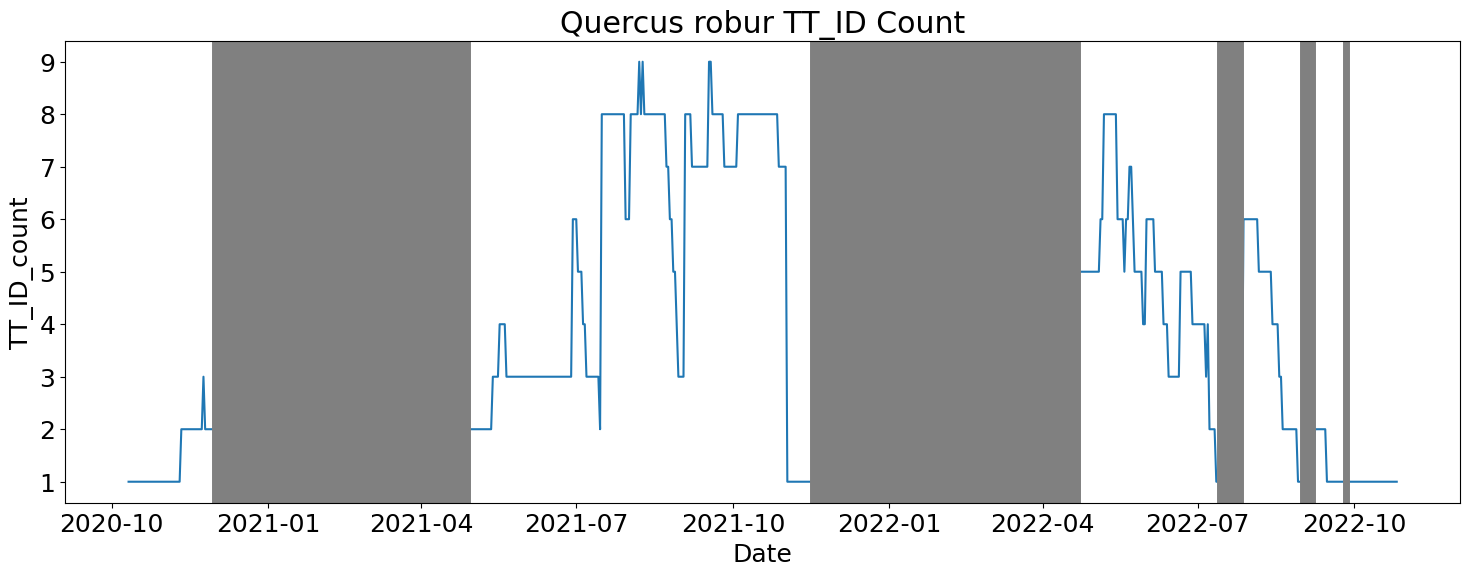

/tmp/ipykernel_21282/3121504476.py:20: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_daily = df_daily.reindex(idx, fill_value=pd.np.nan)


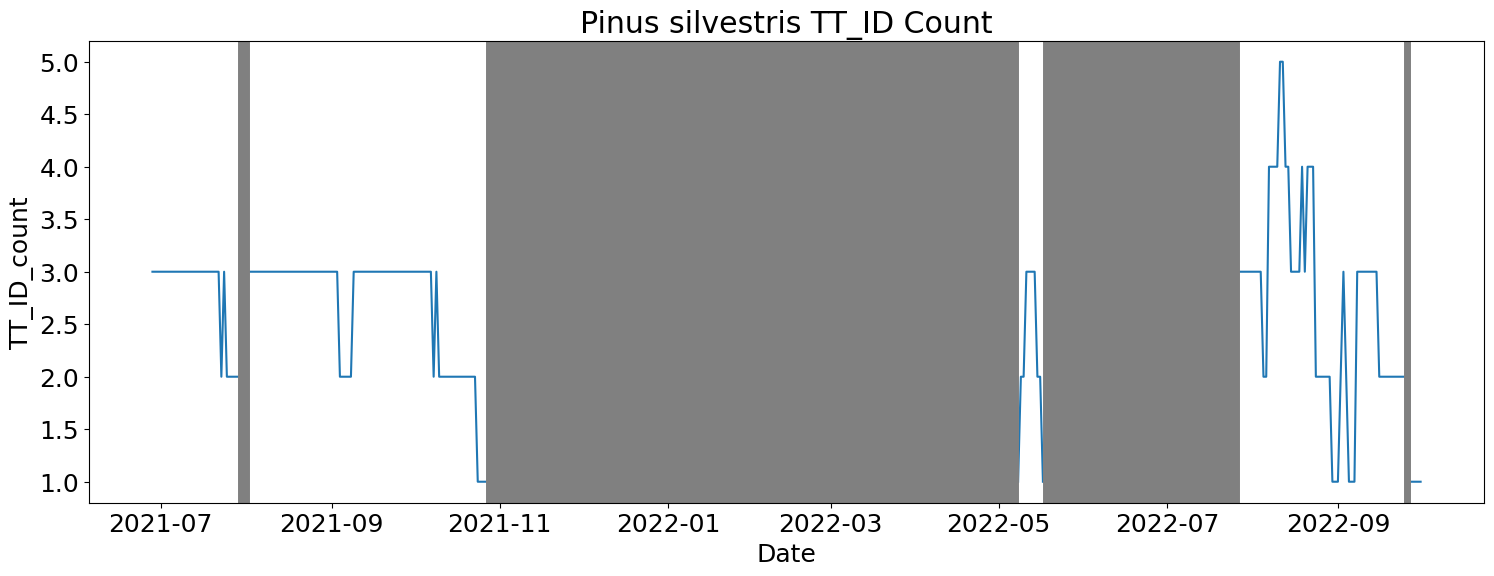

/tmp/ipykernel_21282/3121504476.py:20: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_daily = df_daily.reindex(idx, fill_value=pd.np.nan)


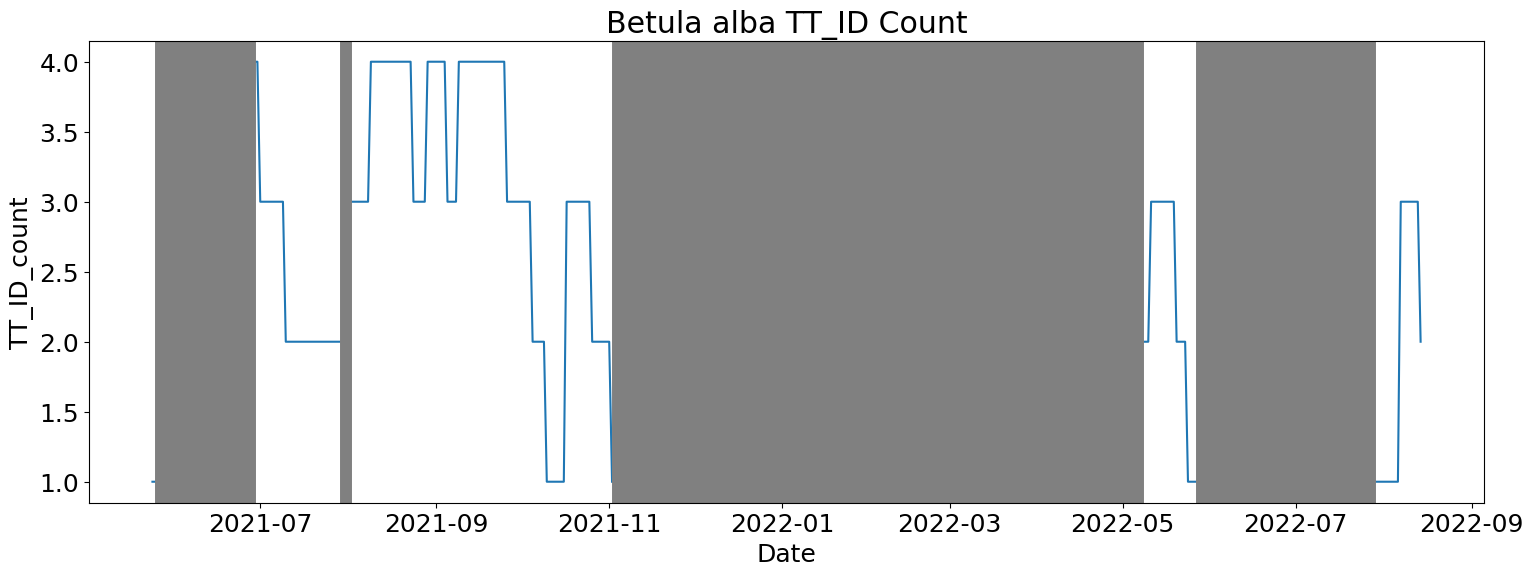

/tmp/ipykernel_21282/3121504476.py:20: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_daily = df_daily.reindex(idx, fill_value=pd.np.nan)


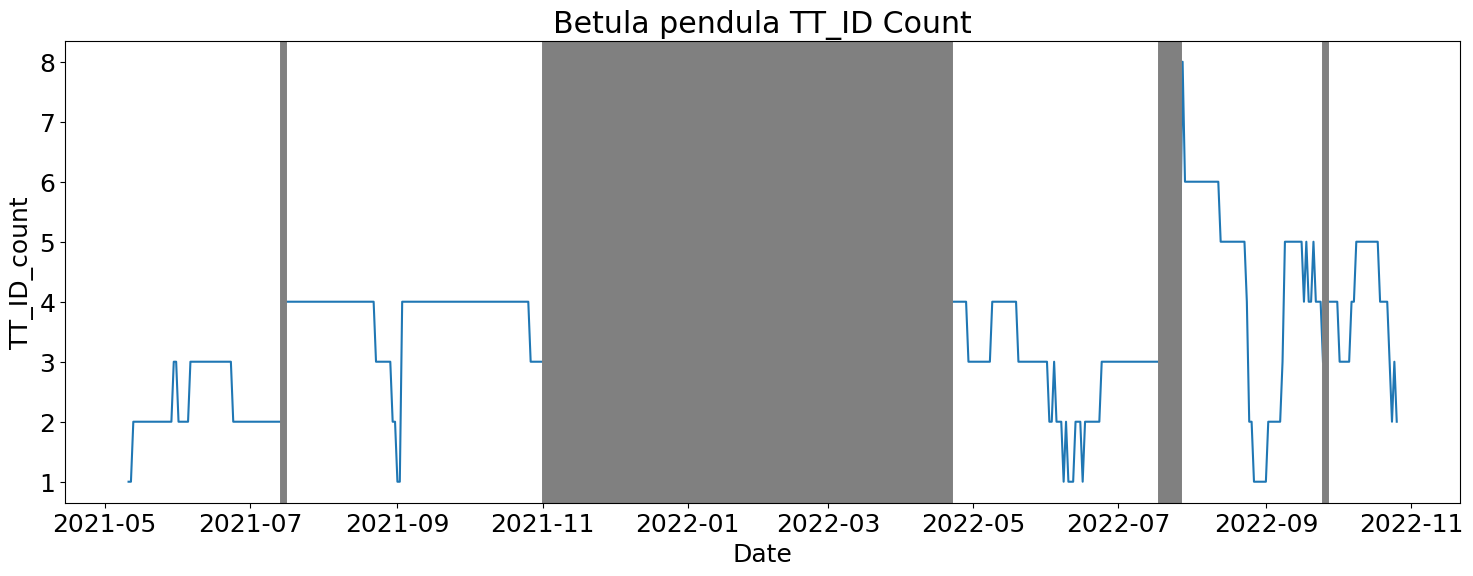

/tmp/ipykernel_21282/3121504476.py:20: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_daily = df_daily.reindex(idx, fill_value=pd.np.nan)


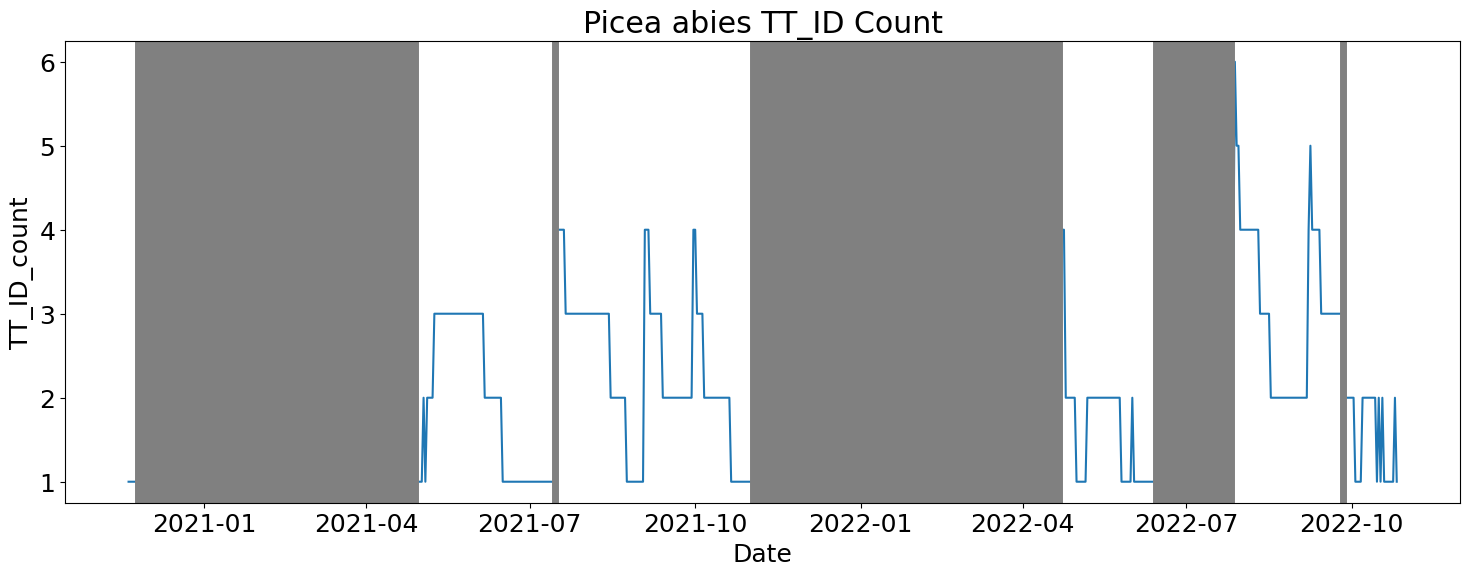

/tmp/ipykernel_21282/3121504476.py:20: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_daily = df_daily.reindex(idx, fill_value=pd.np.nan)


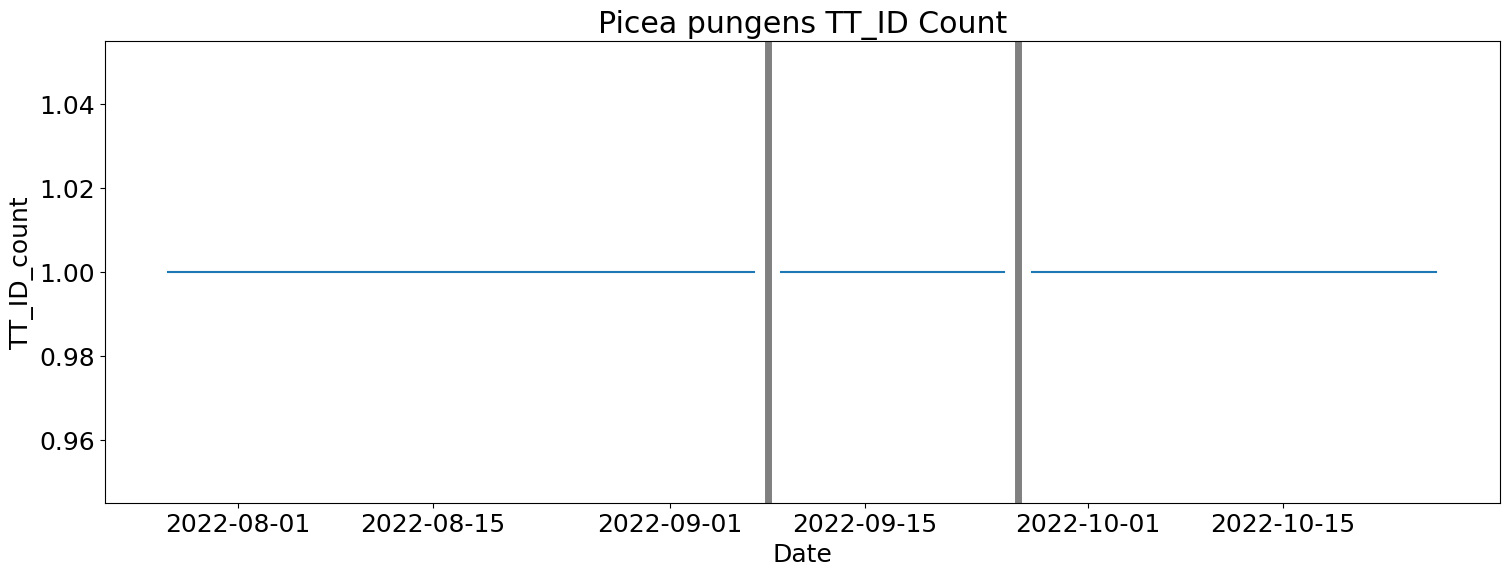

/tmp/ipykernel_21282/3121504476.py:20: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_daily = df_daily.reindex(idx, fill_value=pd.np.nan)


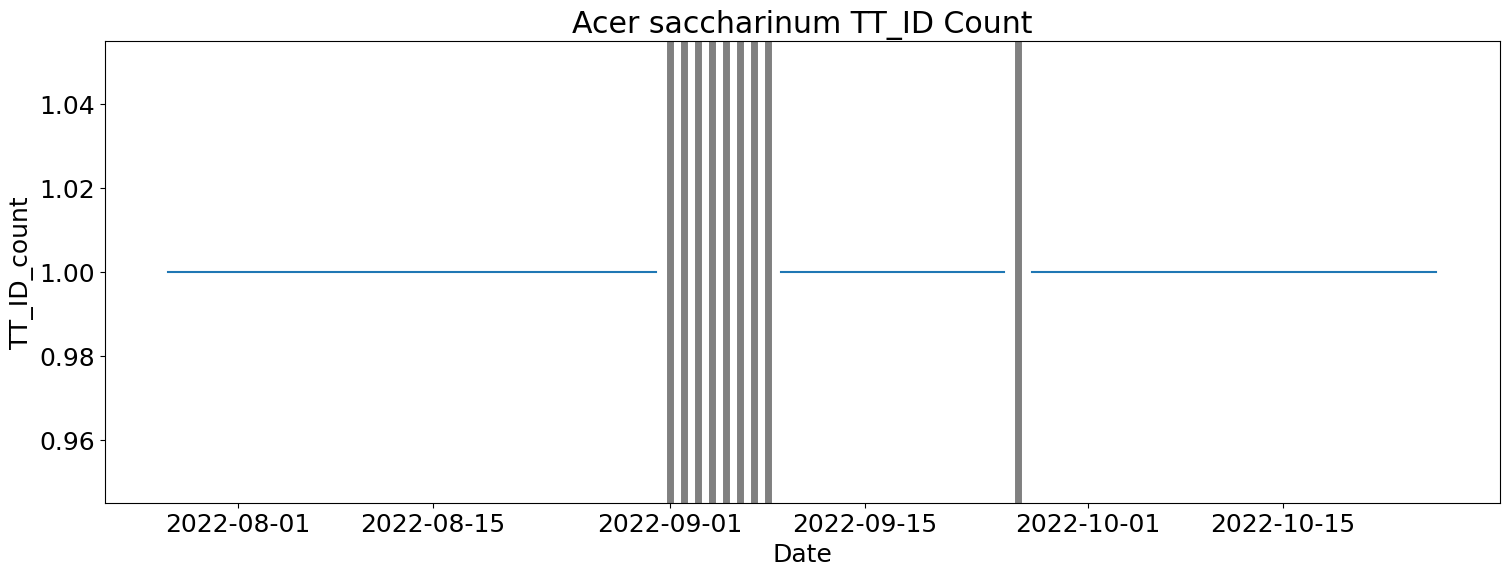

/tmp/ipykernel_21282/3121504476.py:20: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_daily = df_daily.reindex(idx, fill_value=pd.np.nan)


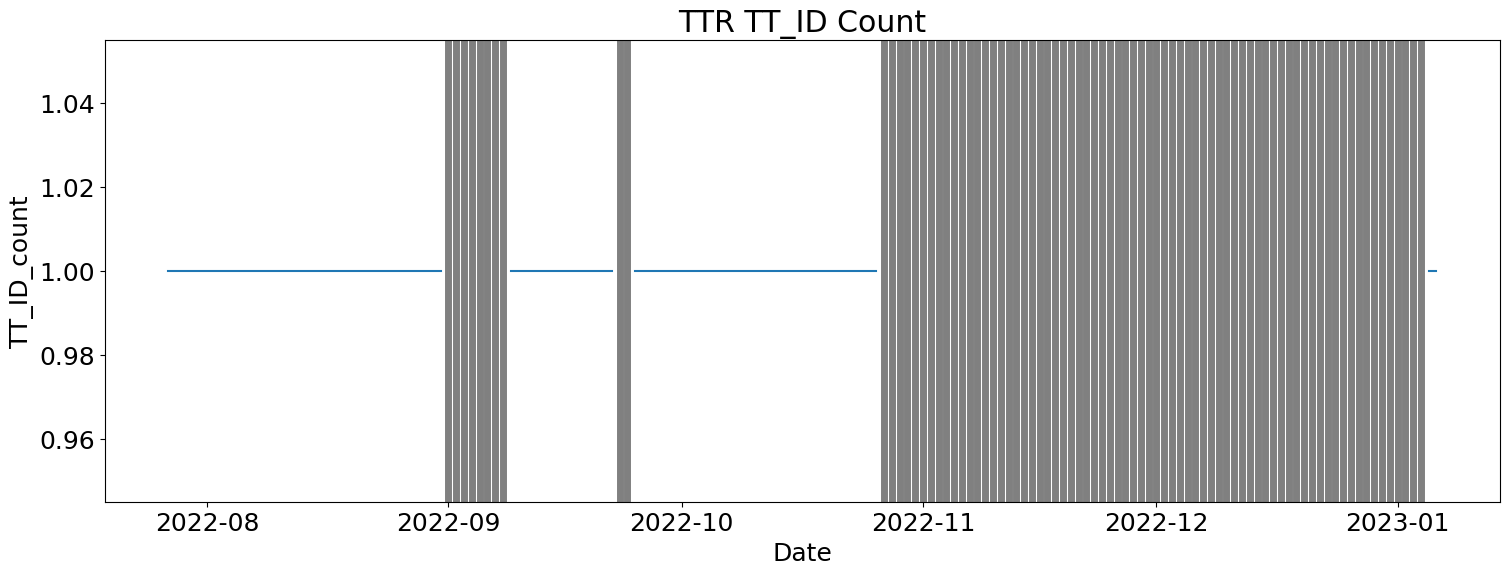

In [94]:
# Get unique species names
species_names = ttdata['Species'].unique()

# Split data by species and save each species as a separate CSV file
for species in species_names:
    species_data = ttdata[ttdata['Species'] == species]
    # species_data.to_csv(f'{species}.csv', index=False)
    # Group by day and count unique TT_IDs
    result_df = species_data.groupby(species_data['Timestamp'].dt.date)['TT_ID'].nunique().reset_index()
    result_df = result_df.rename(columns={'TT_ID': 'TT_ID_count'})

    # set 'Timestamp' column as the index
    df = result_df.set_index('Timestamp')

    # resample data to daily frequency and interpolate missing values
    df_daily = df.interpolate()

    # add NaN values for days with missing data
    idx = pd.date_range(df_daily.index[0], df_daily.index[-1])
    df_daily = df_daily.reindex(idx, fill_value=pd.np.nan)

    # Create plot
    fig, ax = plt.subplots(figsize=(18,6))

    # create plot
    plt.plot(df_daily.index, df_daily['TT_ID_count'])

    # set x-axis label
    plt.xlabel('Date')

    # set y-axis label
    plt.ylabel('TT_ID_count')

    # add title with species name
    plt.title(f'{species} TT_ID Count')

    # set line breaks for missing data
    for i in range(len(df_daily)):
        if pd.isna(df_daily['TT_ID_count'][i]):
            plt.axvline(x=df_daily.index[i], color='grey', linewidth = 5)

    # show plot
    plt.show()

In [13]:
import pandas as pd
import plotly.express as px

# Filter the data for Tilia cordata and 2021 timestamps
filtered_data = ttdata[(ttdata['Species'] == 'Tilia cordata') & (ttdata['years'] == 2021)]

# Group by Site and TT_ID and calculate the mean flux for each group
mean_flux_by_site_id = filtered_data.groupby(['Site', 'TT_ID'])['Flux'].median().reset_index()

# Create a grouped bar chart using Plotly
fig = px.bar(mean_flux_by_site_id, x='Site', y='Flux', labels={'x': 'Site', 'y': 'Median Flux'},
             title='Median Flux for Tilia cordata in 2021 by Site and TT_ID', 
             color='TT_ID', barmode='group')

fig.update_layout(height=600, width=800,
                  font=dict(
                      size=18,
                  ),
                  title=dict(
                      text='Median Flux for Tilia cordata in 2021 by Site and TT_ID',
                      font=dict(
                          size=24,
                      ),
                  ),
                  xaxis=dict(
                      title=dict(
                          text='Site',
                          font=dict(
                              size=20,
                          ),
                      ),
                      tickfont=dict(size=16),
                  ),
                  yaxis=dict(
                      title=dict(
                          text='Median Flux',
                          font=dict(
                              size=20,
                          ),
                      ),
                      tickfont=dict(size=16),
                  ),
                  )

fig.show()


In [4]:
import pandas as pd

# Filter the data for Tilia cordata and 2021 timestamps
filtered_data = ttdata[(ttdata['Species'] == 'Tilia cordata') & (ttdata['years'] == 2021)]

# Group by TT_ID and calculate the max and min flux for each group
max_min_flux_by_id = filtered_data.groupby('TT_ID')['Flux'].agg(['max', 'min']).reset_index()

# Print the result
print(max_min_flux_by_id)

       TT_ID           max       min
0   218A0060  3.580946e+00  0.000000
1   218A0064  2.637251e+00  0.011781
2   218A0069  2.149436e+02  0.020132
3   218A0080  1.169854e+01  0.183953
4   218A0090  2.346314e+01  0.036864
5   218A0117           NaN       NaN
6   218A0141  3.796060e+00  0.022424
7   218A0151  3.660706e+00  0.026097
8   218A0224  7.038944e+18  0.093059
9   218A0236           NaN       NaN
10  218A0237           NaN       NaN
11  218A0292  5.938554e+00  0.024898
12  22AC0F23  9.345147e+00  0.062039
13  22AC0F24  5.793270e+01  0.053462
14  22AC0F25  1.372776e+01  0.024393
15  22AC0F26  6.313933e+01  0.093910


In [29]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Filter the data for Tilia cordata, 2021 timestamps, Flux values less than or equal to 500, and daytime hours (6 AM to 6 PM)
filtered_data = ttdata[(ttdata['Species'] == 'Tilia cordata') & (ttdata['years'] == 2021) & (ttdata['Flux'] <= 5) & (ttdata['hours'] >= 6) & (ttdata['hours'] <= 18)]

# Set the Timestamp column as the DataFrame index
filtered_data = filtered_data.set_index('Timestamp')

# Define a custom function to calculate the mean flux value and standard deviation for each five-day interval
def resample_mean_flux(group):
    mean_flux = group['Flux'].resample('5D').mean()
    std_dev = group['Flux'].resample('5D').std()
    return pd.DataFrame({'Flux': mean_flux, 'Std_dev': std_dev}, index=mean_flux.index)


# Group the data by Site, then apply the custom function
resampled_data = filtered_data.groupby(['Site']).apply(resample_mean_flux).reset_index()

# Drop rows with missing values
resampled_data = resampled_data.dropna()

# Create a line plot using Plotly graph_objects
fig = go.Figure()

# Define a custom color dictionary for each site
site_colors = {
    'Moscow Timiryazev Forest': 'royalblue',
    'RUDN campus': 'forestgreen',
    'Troitsk': 'darkorange'
}

for site in resampled_data['Site'].unique():
    site_data = resampled_data[resampled_data['Site'] == site]
    fig.add_trace(go.Scatter(x=site_data['Timestamp'], y=site_data['Flux'], name=site, mode='lines', line=dict(color=site_colors[site])))
    fig.add_trace(go.Scatter(x=site_data['Timestamp'], y=site_data['Flux'] + site_data['Std_dev'], name=site + ' Upper Bound', mode='lines', line=dict(width=0, color=site_colors[site]), showlegend=False))
    fig.add_trace(go.Scatter(x=site_data['Timestamp'], y=site_data['Flux'] - site_data['Std_dev'], name=site + ' Lower Bound', mode='lines', line=dict(width=0, color=site_colors[site]), fill='tonexty', showlegend=False))


fig.update_layout(
    title=dict(
        text='Mean Flux for Tilia cordata in 2021 by Site (Five-Day Intervals, Daytime) with Confidence Intervals',
        font=dict(
            size=24,
        ),
    ),
    xaxis=dict(
        title=dict(
            text='Time',
            font=dict(
                size=20,
            ),
        ),
    ),
    yaxis=dict(
        title=dict(
            text='Flux',
            font=dict(
                size=20,
            ),
        ),
    ),
    font=dict(
        size=18,
    ),
    height=600,
    width=1500,
)

fig.show()


In [31]:
import geopandas as gpd
import pysal.lib as ps
import pysal.explore.esda as esda

# Load the point shapefile as a GeoDataFrame
point_shapefile = 'shp/tilia_cordata.shp'
gdf = gpd.read_file(point_shapefile)

# Check if the height column exists
if 'height_m' not in gdf.columns:
    raise ValueError("The 'height' column is missing from the GeoDataFrame.")

# Create a spatial weights matrix (using the k-nearest neighbors method, for example)
knn_weights = ps.weights.KNN.from_dataframe(gdf, k=8)  # Change k to the desired number of neighbors
knn_weights.transform = 'r'  # Row-standardize the weights

# Calculate Moran's I
height_values = gdf['height_m'].values
moran = esda.Moran(height_values, knn_weights)

# Display the results
print(f"Moran's I: {moran.I}")
print(f"Expected I under random spatial distribution: {moran.EI}")
print(f"p-value: {moran.p_norm}")

if moran.p_norm < 0.05:
    print("There is significant spatial autocorrelation.")
else:
    print("There is no significant spatial autocorrelation.")


/home/babykelp/anaconda3/lib/python3.9/site-packages/pysal/lib/weights/weights.py:170: UserWarning:

The weights matrix is not fully connected. There are 2041 components



Moran's I: nan
Expected I under random spatial distribution: -1.83463684281015e-06
p-value: nan
There is no significant spatial autocorrelation.
